In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os
import datetime as dt
import string

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context("poster")
sns.set_style("ticks")
sns.set(font_scale=2)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 15000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

/Users/abbieschindler/opt/anaconda3/envs/analysis/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


### RFID data

#### Get paths for files to process

In [2]:
#create list of dir paths
RFID_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/RFID/round1'
    
RFID_file_names = os.listdir(RFID_path)

RFID_data_dir_paths = []

for file in RFID_file_names:
    int_path = RFID_path + '/' + file
    RFID_data_dir_paths.append(int_path)
    
RFID_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/RFID/round1/Idspyder-22.11.11.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/RFID/round1/Idspyder-22.12.04.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/RFID/round1/Idspyder-22.12.02.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/RFID/round1/Idspyder-22.11.25.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/RFID/round1/Idspyder-22.11.18.csv']

#### Clean df and fix datetime

In [3]:
path = RFID_data_dir_paths[2]

data_RFID_int = pd.read_csv(path, sep=';', encoding='utf-16')

data_RFID_int = pd.DataFrame(data = data_RFID_int)
print(data_RFID_int.shape)

data_RFID_int.head(50)

(22954, 14)


,DateTime,IdRFID,IdLabel,unitLabel,eventDuration,sense1duration,sense1Events,senseRFIDrecords,outFuncLabel,outLabel,SystemMsg,MsgValue1,MsgValue2,MsgValue3
0,#ID-Device,Spyder1.01,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,#ID-Device,Spyder1.02,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#ID-Device,Spyder1.03,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,#ID-Device,Spyder1.04,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,#ID-Device,Spyder1.05,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,#ID-Device,Spyder1.06,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,#ID-Device,Spyder1.07,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,#ID-Device,Spyder1.08,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,#ID-Device,Spyder1.09,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,#ID-Device,Spyder1.10,0,0,0.0,SAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
row_drop = 25

data_RFID = pd.DataFrame()

for path in RFID_data_dir_paths:
    print(path)

    if path.split('/')[-1] == '.DS_Store':
        continue
    
    #data_RFID_int['file'] = path.split('/')[-1]
    
    #create data table
    data_RFID_int = pd.read_csv(path, sep=';', encoding='utf-16')
    data_RFID_int = pd.DataFrame(data = data_RFID_int)
    data_RFID_int = data_RFID_int.iloc[row_drop: , :]
    print(data_RFID_int.shape)
    
    #add file name
    data_RFID_int['RFID_file'] = path.split('/')[-1]
                                            
    #drop rows with no event duration
    data_RFID_int = data_RFID_int[~data_RFID_int['eventDuration'].isna()]
    print(data_RFID_int.shape)
    data_RFID_int = data_RFID_int[~data_RFID_int['DateTime'].isna()]
    print(data_RFID_int.shape)

    #convert from ms to sec
    data_RFID_int['eventDuration'] = data_RFID_int['eventDuration']/1000
    #clean up and create datetime columns
    data_RFID_int['start_datetime'] = pd.to_datetime(data_RFID_int['DateTime'], unit='d')
    #can't figure out datetime format so hard code for now
    data_RFID_int['RFID_datetime_start'] = [x.replace(year = 2022) - dt.timedelta(days = 1) for x in data_RFID_int['start_datetime']] 
    data_RFID_int['RFID_date'] = data_RFID_int['RFID_datetime_start'].dt.date 
    data_RFID_int['RFID_day'] = data_RFID_int['RFID_datetime_start'].dt.day 
    data_RFID_int['RFID_time_start'] = [x.split(' ')[1] for x in data_RFID_int['RFID_datetime_start'].dt.strftime("%Y-%m-%d %H:%M:%S")]
    data_RFID_int['RFID_hour'] = data_RFID_int['RFID_datetime_start'].dt.hour
    data_RFID_int['RFID_min'] = data_RFID_int['RFID_datetime_start'].dt.minute
    data_RFID_int['RFID_second'] = data_RFID_int['RFID_datetime_start'].dt.second

    if data_RFID.empty:
        data_RFID = data_RFID_int
    else:
        data_RFID = pd.concat([data_RFID, data_RFID_int], axis=0)
        
    print(data_RFID.shape,'\n')

#clean columns
data_RFID = data_RFID[['RFID_file', 'IdRFID', 'unitLabel', 'eventDuration',
       'RFID_datetime_start', 'RFID_date',
       'RFID_day', 'RFID_time_start', 'RFID_hour', 'RFID_min', 'RFID_second']]

print(data_RFID.shape,'\n')

data_RFID.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/RFID/round1/Idspyder-22.11.11.csv
(105077, 14)
(105074, 15)
(105074, 15)
(105074, 23) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/RFID/round1/Idspyder-22.12.04.csv
(50195, 14)
(50194, 15)
(50194, 15)
(155268, 23) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/RFID/round1/Idspyder-22.12.02.csv
(22929, 14)
(22928, 15)
(22928, 15)
(178196, 23) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/RFID/round1/Idspyder-22.11.25.csv
(80052, 14)
(80051, 15)
(80051, 15)
(258247, 23) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/RFID/round1/Idspyder-22.11.18.csv
(89589, 14)
(89588, 15)
(89588, 15)
(347835, 23) 

(347835, 11) 



,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second
25,Idspyder-22.11.11.csv,041AC16185,Spyder1.15,0.075,2022-11-11 09:41:56.964969600,2022-11-11,11,09:41:56,9,41,56
26,Idspyder-22.11.11.csv,041AC169A3,Spyder1.16,0.228,2022-11-11 09:41:57.746976000,2022-11-11,11,09:41:57,9,41,57
27,Idspyder-22.11.11.csv,041AC169A3,Spyder1.16,0.075,2022-11-11 09:41:59.190979200,2022-11-11,11,09:41:59,9,41,59
28,Idspyder-22.11.11.csv,041AC1660D,Spyder1.07,0.075,2022-11-11 09:41:59.734003200,2022-11-11,11,09:41:59,9,41,59
29,Idspyder-22.11.11.csv,041AC1660D,Spyder1.06,0.814,2022-11-11 09:41:59.775043200,2022-11-11,11,09:41:59,9,41,59


In [5]:
data_RFID['RFID_day'].value_counts()

18    17067
12    16689
19    16351
17    15387
14    15209
16    14010
25    13956
20    13582
15    13321
2     13002
11    12846
21    12689
30    11328
26    11256
1     11210
24    11085
5     10970
28    10939
3     10625
27    10611
22    10584
7     10388
13    10299
23    10282
4     10153
29    9974 
8     9656 
6     9228 
9     5138 
Name: RFID_day, dtype: int64

In [6]:
data_RFID['IdRFID'].value_counts()

041AC02DFB    33146
041AC1659C    28859
041AC16B8D    26338
041AC16566    25853
041AC163E0    25749
041AC035B7    23177
041AC16626    21738
041AC16A21    20763
041AC16024    19305
041AC1685B    17176
041ABFF7BC    16607
041AC15EEE    16176
041AC166CF    15741
041AC1662C    15459
041AC16229    14353
041AC165C3    13553
041AC161AF    13028
041AC16282    683  
041A55583F    29   
041AC16B67    27   
041AC16982    19   
041AC16185    12   
041AC169DC    9    
041AC169A3    9    
041AC1610F    8    
041AC16B88    7    
041AC1660D    6    
041AC163A9    5    
Name: IdRFID, dtype: int64

#### Compute endtime 

In [7]:
#compute end time for each eventDuration
def add_duration(a, b):
    newtime = a + dt.timedelta(0, b)

    return newtime

data_RFID['RFID_datetime_end'] = data_RFID.apply(lambda row: add_duration(row['RFID_datetime_start'], row['eventDuration']), axis=1)
data_RFID['RFID_time_end'] = [x.split(' ')[1] for x in data_RFID['RFID_datetime_end'].dt.strftime("%Y-%m-%d %H:%M:%S")]

print(data_RFID.shape)
data_RFID.head()

(347835, 13)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end
25,Idspyder-22.11.11.csv,041AC16185,Spyder1.15,0.075,2022-11-11 09:41:56.964969600,2022-11-11,11,09:41:56,9,41,56,2022-11-11 09:41:57.039969600,09:41:57
26,Idspyder-22.11.11.csv,041AC169A3,Spyder1.16,0.228,2022-11-11 09:41:57.746976000,2022-11-11,11,09:41:57,9,41,57,2022-11-11 09:41:57.974976000,09:41:57
27,Idspyder-22.11.11.csv,041AC169A3,Spyder1.16,0.075,2022-11-11 09:41:59.190979200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:41:59.265979200,09:41:59
28,Idspyder-22.11.11.csv,041AC1660D,Spyder1.07,0.075,2022-11-11 09:41:59.734003200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:41:59.809003200,09:41:59
29,Idspyder-22.11.11.csv,041AC1660D,Spyder1.06,0.814,2022-11-11 09:41:59.775043200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:42:00.589043200,09:42:00


#### Add day, hour, and min counts

In [8]:
#column of running day count
dat_map = dict(zip(data_RFID['RFID_date'].sort_values().unique(), np.arange(0,len(data_RFID['RFID_date'].unique()))))
data_RFID['RFID_day_count'] = data_RFID['RFID_date'].map(dat_map)

#column of running min and second count within each day
data_RFID['RFID_min_count'] = (data_RFID['RFID_hour']*60) + data_RFID['RFID_min'] 
data_RFID['RFID_sec_count'] = (data_RFID['RFID_min_count']*60) + data_RFID['RFID_second'] 

#column of running hour and minute count across all days
data_RFID['RFID_hour_count_running'] = (data_RFID['RFID_day_count']*24) + data_RFID['RFID_hour'] - 24
data_RFID['RFID_min_count_running'] = (data_RFID['RFID_hour_count_running']*60) + data_RFID['RFID_min'] 
data_RFID['RFID_sec_count_running'] = (data_RFID['RFID_min_count_running']*60) + data_RFID['RFID_second'] - 60

print(data_RFID.shape)
data_RFID.head()

(347835, 19)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running
25,Idspyder-22.11.11.csv,041AC16185,Spyder1.15,0.075,2022-11-11 09:41:56.964969600,2022-11-11,11,09:41:56,9,41,56,2022-11-11 09:41:57.039969600,09:41:57,0,581,34916,-15,-859,-51544
26,Idspyder-22.11.11.csv,041AC169A3,Spyder1.16,0.228,2022-11-11 09:41:57.746976000,2022-11-11,11,09:41:57,9,41,57,2022-11-11 09:41:57.974976000,09:41:57,0,581,34917,-15,-859,-51543
27,Idspyder-22.11.11.csv,041AC169A3,Spyder1.16,0.075,2022-11-11 09:41:59.190979200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:41:59.265979200,09:41:59,0,581,34919,-15,-859,-51541
28,Idspyder-22.11.11.csv,041AC1660D,Spyder1.07,0.075,2022-11-11 09:41:59.734003200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:41:59.809003200,09:41:59,0,581,34919,-15,-859,-51541
29,Idspyder-22.11.11.csv,041AC1660D,Spyder1.06,0.814,2022-11-11 09:41:59.775043200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:42:00.589043200,09:42:00,0,581,34919,-15,-859,-51541


In [9]:
dat_map

{datetime.date(2022, 11, 11): 0,
 datetime.date(2022, 11, 12): 1,
 datetime.date(2022, 11, 13): 2,
 datetime.date(2022, 11, 14): 3,
 datetime.date(2022, 11, 15): 4,
 datetime.date(2022, 11, 16): 5,
 datetime.date(2022, 11, 17): 6,
 datetime.date(2022, 11, 18): 7,
 datetime.date(2022, 11, 19): 8,
 datetime.date(2022, 11, 20): 9,
 datetime.date(2022, 11, 21): 10,
 datetime.date(2022, 11, 22): 11,
 datetime.date(2022, 11, 23): 12,
 datetime.date(2022, 11, 24): 13,
 datetime.date(2022, 11, 25): 14,
 datetime.date(2022, 11, 26): 15,
 datetime.date(2022, 11, 27): 16,
 datetime.date(2022, 11, 28): 17,
 datetime.date(2022, 11, 29): 18,
 datetime.date(2022, 11, 30): 19,
 datetime.date(2022, 12, 1): 20,
 datetime.date(2022, 12, 2): 21,
 datetime.date(2022, 12, 3): 22,
 datetime.date(2022, 12, 4): 23,
 datetime.date(2022, 12, 5): 24,
 datetime.date(2022, 12, 6): 25,
 datetime.date(2022, 12, 7): 26,
 datetime.date(2022, 12, 8): 27,
 datetime.date(2022, 12, 9): 28}

#### Light/dark mapping

In [10]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_RFID['ld_seg'] = data_RFID['RFID_hour'].apply(assign_ld)

print(data_RFID.shape)
data_RFID.head()


(347835, 20)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg
25,Idspyder-22.11.11.csv,041AC16185,Spyder1.15,0.075,2022-11-11 09:41:56.964969600,2022-11-11,11,09:41:56,9,41,56,2022-11-11 09:41:57.039969600,09:41:57,0,581,34916,-15,-859,-51544,light
26,Idspyder-22.11.11.csv,041AC169A3,Spyder1.16,0.228,2022-11-11 09:41:57.746976000,2022-11-11,11,09:41:57,9,41,57,2022-11-11 09:41:57.974976000,09:41:57,0,581,34917,-15,-859,-51543,light
27,Idspyder-22.11.11.csv,041AC169A3,Spyder1.16,0.075,2022-11-11 09:41:59.190979200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:41:59.265979200,09:41:59,0,581,34919,-15,-859,-51541,light
28,Idspyder-22.11.11.csv,041AC1660D,Spyder1.07,0.075,2022-11-11 09:41:59.734003200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:41:59.809003200,09:41:59,0,581,34919,-15,-859,-51541,light
29,Idspyder-22.11.11.csv,041AC1660D,Spyder1.06,0.814,2022-11-11 09:41:59.775043200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:42:00.589043200,09:42:00,0,581,34919,-15,-859,-51541,light


In [11]:
ld_mapping_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/meta/ld_mapping.xlsx'

ld_mapping = pd.read_excel(ld_mapping_path)
ld_mapping = pd.DataFrame(data = ld_mapping)
print(ld_mapping.shape)
ld_mapping.head()

(97, 6)


,day,ld_seg,ld_cycle,ld_day,alcohol_on,after_weekend
0,0,light,light,0,yes,0
1,0,dark_pm,dark,1,yes,0
2,1,dark_am,dark,1,yes,0
3,1,light,light,1,yes,0
4,1,dark_pm,dark,2,yes,0


In [12]:
data_RFID = data_RFID.merge(ld_mapping, right_on=['day', 'ld_seg'], left_on=['RFID_day_count', 'ld_seg'])
print(data_RFID.shape)
data_RFID.head()

(347835, 25)


,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld_cycle,ld_day,alcohol_on,after_weekend
0,Idspyder-22.11.11.csv,041AC16185,Spyder1.15,0.075,2022-11-11 09:41:56.964969600,2022-11-11,11,09:41:56,9,41,56,2022-11-11 09:41:57.039969600,09:41:57,0,581,34916,-15,-859,-51544,light,0,light,0,yes,0
1,Idspyder-22.11.11.csv,041AC169A3,Spyder1.16,0.228,2022-11-11 09:41:57.746976000,2022-11-11,11,09:41:57,9,41,57,2022-11-11 09:41:57.974976000,09:41:57,0,581,34917,-15,-859,-51543,light,0,light,0,yes,0
2,Idspyder-22.11.11.csv,041AC169A3,Spyder1.16,0.075,2022-11-11 09:41:59.190979200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:41:59.265979200,09:41:59,0,581,34919,-15,-859,-51541,light,0,light,0,yes,0
3,Idspyder-22.11.11.csv,041AC1660D,Spyder1.07,0.075,2022-11-11 09:41:59.734003200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:41:59.809003200,09:41:59,0,581,34919,-15,-859,-51541,light,0,light,0,yes,0
4,Idspyder-22.11.11.csv,041AC1660D,Spyder1.06,0.814,2022-11-11 09:41:59.775043200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:42:00.589043200,09:42:00,0,581,34919,-15,-859,-51541,light,0,light,0,yes,0


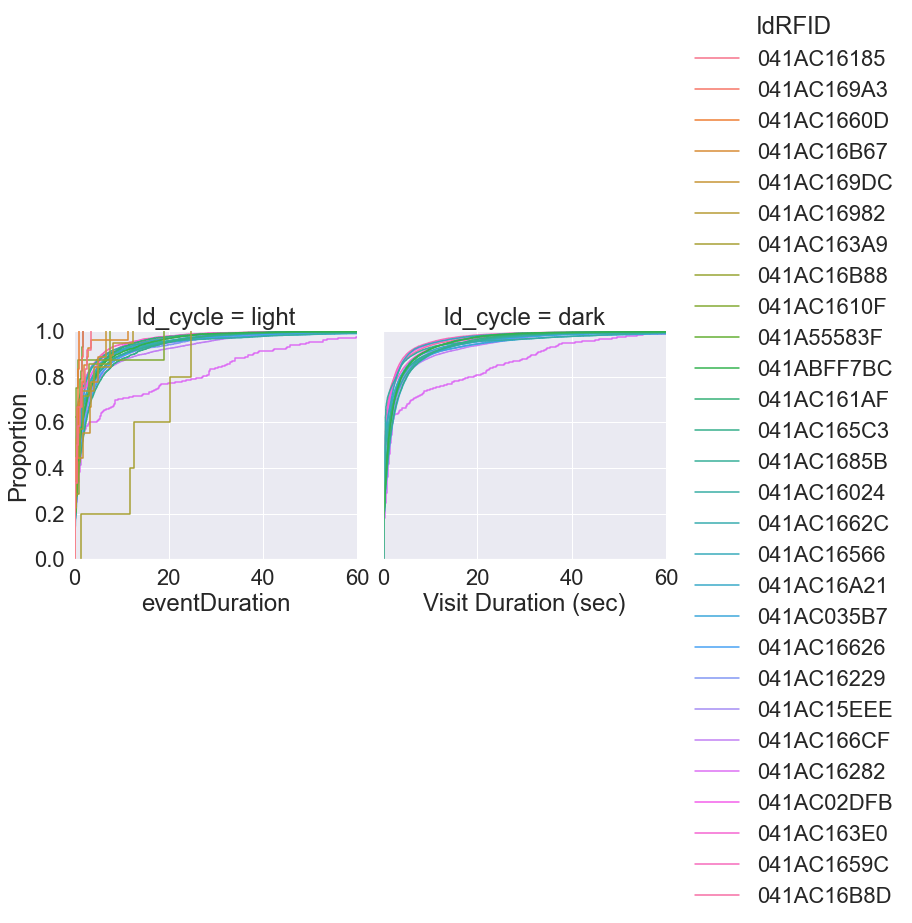

In [13]:
sns.displot(data=data_RFID, x="eventDuration", kind="ecdf", hue='IdRFID', col='ld_cycle')
plt.xlabel('Visit Duration (sec)')
plt.xlim(0, 60)
plt.show()

In [14]:
data_RFID.groupby(['unitLabel'])['IdRFID'].value_counts()

unitLabel   IdRFID    
Spyder1.01  041ABFF7BC    7001 
            041AC161AF    6527 
            041AC1685B    6480 
            041AC165C3    5804 
            041A55583F    1    
Spyder1.02  041AC1685B    5780 
            041ABFF7BC    4481 
            041AC165C3    2687 
            041AC161AF    2267 
            041A55583F    2    
Spyder1.03  041ABFF7BC    2543 
            041AC1685B    2529 
            041AC165C3    2370 
            041AC161AF    1936 
            041A55583F    1    
Spyder1.04  041AC165C3    2691 
            041ABFF7BC    2581 
            041AC1685B    2386 
            041AC161AF    2297 
            041A55583F    2    
Spyder1.05  041AC16566    6407 
            041AC16A21    5271 
            041AC1662C    4531 
            041AC16024    4041 
            041A55583F    1    
            041AC1660D    1    
Spyder1.06  041AC16024    9731 
            041AC16A21    8095 
            041AC16566    8023 
            041AC1662C    5175 
            041AC

#### Map unitLabel and bottle contents

In [15]:
RFID_bottle_assignment_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/meta/bottle_assignment_RFID.xlsx'

RFID_bottle_assignment = pd.read_excel(RFID_bottle_assignment_path)
RFID_bottle_assignment = pd.DataFrame(data = RFID_bottle_assignment)
print(RFID_bottle_assignment.shape)
RFID_bottle_assignment

(11, 27)


,cohort,RFID_file,VDM_file,Spyder1.01,Spyder1.02,Spyder1.03,Spyder1.04,Spyder1.05,Spyder1.06,Spyder1.07,Spyder1.08,Spyder1.09,Spyder1.10,Spyder1.11,Spyder1.12,Spyder1.13,Spyder1.14,Spyder1.15,Spyder1.16,Spyder1.17,Spyder1.18,Spyder1.19,Spyder1.20,Spyder1.21,Spyder1.22,Spyder1.23,Spyder1.24
0,etoh,Idspyder-22.11.11.csv,w_e05_e10_e2.5_MPc1_221111.csv,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02
1,etoh,Idspyder-22.11.11.csv,w_e05_e10_e2.5_MPc1_221114.csv,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02
2,etoh,Idspyder-22.11.18.csv,w_e05_e10_e2.5_MPc1_221118.csv,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02
3,etoh,Idspyder-22.11.25.csv,w_e05_e10_e2.5_MPc1_221125.csv,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02
4,etoh,Idspyder-22.12.02.csv,w_e05_e10_e2.5_MPc1_221202.csv,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02
5,etoh,Idspyder-22.12.04.csv,e05_e10_e2.5_w_MPc1_221204.csv,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water,etoh_05,etoh_10,etoh_02,water
6,etoh,Idspyder-23.01.06.csv,w_e10_e20_e05_MPc1_230106.csv,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05
7,etoh,Idspyder-23.01.13.csv,w_e10_e20_e05_MPc1_230113.csv,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05
8,etoh,Idspyder-23.01.20.csv,w_e10_e20_e05_MPc1_230120.csv,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05
9,etoh,Idspyder-23.01.27.csv,w_e10_e20_e05_MPc1_230127.csv,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05,water,etoh_10,etoh_20,etoh_05


In [16]:
data_RFID_bottle = pd.DataFrame()

for file in data_RFID['RFID_file'].unique():
    print(file)
    d_int = data_RFID[data_RFID['RFID_file']==file]
    
    RFID_bottle_map = RFID_bottle_assignment[RFID_bottle_assignment['RFID_file']==file].reset_index().loc[0,'Spyder1.01':'Spyder1.24'].to_dict()
    d_int['unitLabel_drink'] = d_int['unitLabel'].map(RFID_bottle_map)
    
    if data_RFID_bottle.empty:
        data_RFID_bottle = d_int
    else:
        data_RFID_bottle = pd.concat([data_RFID_bottle, d_int], axis=0)
        
    print(data_RFID_bottle.shape,'\n')
    
data_RFID_bottle.head()

Idspyder-22.11.11.csv
(105074, 26) 

Idspyder-22.11.18.csv
(194662, 26) 

Idspyder-22.12.04.csv
(244856, 26) 

Idspyder-22.12.02.csv
(267784, 26) 

Idspyder-22.11.25.csv
(347835, 26) 



,RFID_file,IdRFID,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld_cycle,ld_day,alcohol_on,after_weekend,unitLabel_drink
0,Idspyder-22.11.11.csv,041AC16185,Spyder1.15,0.075,2022-11-11 09:41:56.964969600,2022-11-11,11,09:41:56,9,41,56,2022-11-11 09:41:57.039969600,09:41:57,0,581,34916,-15,-859,-51544,light,0,light,0,yes,0,etoh_10
1,Idspyder-22.11.11.csv,041AC169A3,Spyder1.16,0.228,2022-11-11 09:41:57.746976000,2022-11-11,11,09:41:57,9,41,57,2022-11-11 09:41:57.974976000,09:41:57,0,581,34917,-15,-859,-51543,light,0,light,0,yes,0,etoh_02
2,Idspyder-22.11.11.csv,041AC169A3,Spyder1.16,0.075,2022-11-11 09:41:59.190979200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:41:59.265979200,09:41:59,0,581,34919,-15,-859,-51541,light,0,light,0,yes,0,etoh_02
3,Idspyder-22.11.11.csv,041AC1660D,Spyder1.07,0.075,2022-11-11 09:41:59.734003200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:41:59.809003200,09:41:59,0,581,34919,-15,-859,-51541,light,0,light,0,yes,0,etoh_10
4,Idspyder-22.11.11.csv,041AC1660D,Spyder1.06,0.814,2022-11-11 09:41:59.775043200,2022-11-11,11,09:41:59,9,41,59,2022-11-11 09:42:00.589043200,09:42:00,0,581,34919,-15,-859,-51541,light,0,light,0,yes,0,etoh_05


In [17]:
data_RFID = data_RFID_bottle

data_RFID.groupby('unitLabel_drink')['unitLabel'].value_counts()

unitLabel_drink  unitLabel 
etoh_02          Spyder1.24    21554
                 Spyder1.08    12061
                 Spyder1.20    8251 
                 Spyder1.04    7654 
                 Spyder1.16    5244 
                 Spyder1.23    4658 
                 Spyder1.19    3352 
                 Spyder1.12    2752 
                 Spyder1.07    2173 
                 Spyder1.15    1776 
                 Spyder1.11    1164 
                 Spyder1.03    984  
etoh_05          Spyder1.06    28323
                 Spyder1.22    27164
                 Spyder1.02    13059
                 Spyder1.18    10528
                 Spyder1.10    4197 
                 Spyder1.01    3924 
                 Spyder1.05    3033 
                 Spyder1.14    2945 
                 Spyder1.21    2138 
                 Spyder1.17    1898 
                 Spyder1.09    533  
                 Spyder1.13    445  
etoh_10          Spyder1.23    29355
                 Spyder1.07    12380
          

#### Add metadata and clean

In [18]:
meta_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/meta/meta_data.xlsx'
meta_data = pd.read_excel(meta_path)
meta_data = pd.DataFrame(data = meta_data)

data_RFID_final = meta_data.merge(data_RFID.reset_index(), on='IdRFID', sort=False)

print(data_RFID_final.shape)
data_RFID_final.head()

(347704, 45)


,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,22_11_11,22_11_18,22_11_25,22_12_02,23_01_06,23_01_13,23_01_20,23_01_27,index,RFID_file,unitLabel,eventDuration,RFID_datetime_start,RFID_date,RFID_day,RFID_time_start,RFID_hour,RFID_min,RFID_second,RFID_datetime_end,RFID_time_end,RFID_day_count,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,ld_seg,day,ld_cycle,ld_day,alcohol_on,after_weekend,unitLabel_drink
0,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,130,Idspyder-22.11.11.csv,Spyder1.20,2.290,2022-11-11 18:08:38.854982399,2022-11-11,11,18:08:38,18,8,38,2022-11-11 18:08:41.144982399,18:08:41,0,1088,65318,-6,-352,-21142,dark_pm,0,dark,1,yes,0,etoh_02
1,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,133,Idspyder-22.11.11.csv,Spyder1.01,5.366,2022-11-11 18:09:34.690032000,2022-11-11,11,18:09:34,18,9,34,2022-11-11 18:09:40.056032000,18:09:40,0,1089,65374,-6,-351,-21086,dark_pm,0,dark,1,yes,0,water
2,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,135,Idspyder-22.11.11.csv,Spyder1.01,5.264,2022-11-11 18:10:32.770012799,2022-11-11,11,18:10:32,18,10,32,2022-11-11 18:10:38.034012799,18:10:38,0,1090,65432,-6,-350,-21028,dark_pm,0,dark,1,yes,0,water
3,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,136,Idspyder-22.11.11.csv,Spyder1.01,0.075,2022-11-11 18:10:39.149011200,2022-11-11,11,18:10:39,18,10,39,2022-11-11 18:10:39.224011200,18:10:39,0,1090,65439,-6,-350,-21021,dark_pm,0,dark,1,yes,0,water
4,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,138,Idspyder-22.11.11.csv,Spyder1.01,0.075,2022-11-11 18:10:48.400982400,2022-11-11,11,18:10:48,18,10,48,2022-11-11 18:10:48.475982400,18:10:48,0,1090,65448,-6,-350,-21012,dark_pm,0,dark,1,yes,0,water


In [19]:
data_RFID_final['IdRFID'].value_counts()

041AC02DFB    33146
041AC1659C    28859
041AC16B8D    26338
041AC16566    25853
041AC163E0    25749
041AC035B7    23177
041AC16626    21738
041AC16A21    20763
041AC16024    19305
041AC1685B    17176
041ABFF7BC    16607
041AC15EEE    16176
041AC166CF    15741
041AC1662C    15459
041AC16229    14353
041AC165C3    13553
041AC161AF    13028
041AC16282    683  
Name: IdRFID, dtype: int64

In [20]:
data_RFID_final.columns.values

array(['Round', 'Build', 'Startdate', 'Timepoint', 'Cage', 'IdRFID',
       'Animal', 'ARF_Cage', 'Injury', 'Sex', 'Cage_N', '22_11_11',
       '22_11_18', '22_11_25', '22_12_02', '23_01_06', '23_01_13',
       '23_01_20', '23_01_27', 'index', 'RFID_file', 'unitLabel',
       'eventDuration', 'RFID_datetime_start', 'RFID_date', 'RFID_day',
       'RFID_time_start', 'RFID_hour', 'RFID_min', 'RFID_second',
       'RFID_datetime_end', 'RFID_time_end', 'RFID_day_count',
       'RFID_min_count', 'RFID_sec_count', 'RFID_hour_count_running',
       'RFID_min_count_running', 'RFID_sec_count_running', 'ld_seg',
       'day', 'ld_cycle', 'ld_day', 'alcohol_on', 'after_weekend',
       'unitLabel_drink'], dtype=object)

In [21]:
data_RFID_final = data_RFID_final[['Round', 'Timepoint', 'Cage', 'IdRFID', 'Animal', 'Injury', 'Sex', 'Cage_N', 
                                   'unitLabel_drink', 'unitLabel', 'eventDuration',
                                   'ld_cycle', 'ld_day', 'day', 
                                   'alcohol_on', 'after_weekend',
                                   'RFID_hour', 'RFID_min', 'RFID_second',
                                   'RFID_datetime_start', 'RFID_datetime_end', 'RFID_time_start', 'RFID_time_end', 
                                   'RFID_min_count', 'RFID_sec_count', 
                                   'RFID_hour_count_running', 'RFID_min_count_running', 'RFID_sec_count_running', 
                                   'RFID_file', '22_11_11', '22_11_18', '22_11_25', '22_12_02', 
                                   '23_01_06', '23_01_13', '23_01_20', '23_01_27',]]

print(data_RFID_final.shape)
data_RFID_final.head()

(347704, 37)


,Round,Timepoint,Cage,IdRFID,Animal,Injury,Sex,Cage_N,unitLabel_drink,unitLabel,eventDuration,ld_cycle,ld_day,day,alcohol_on,after_weekend,RFID_hour,RFID_min,RFID_second,RFID_datetime_start,RFID_datetime_end,RFID_time_start,RFID_time_end,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,RFID_file,22_11_11,22_11_18,22_11_25,22_12_02,23_01_06,23_01_13,23_01_20,23_01_27
0,MPc1,1m,1,041ABFF7BC,2154,sham,male,4,etoh_02,Spyder1.20,2.290,dark,1,0,yes,0,18,8,38,2022-11-11 18:08:38.854982399,2022-11-11 18:08:41.144982399,18:08:38,18:08:41,1088,65318,-6,-352,-21142,Idspyder-22.11.11.csv,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8
1,MPc1,1m,1,041ABFF7BC,2154,sham,male,4,water,Spyder1.01,5.366,dark,1,0,yes,0,18,9,34,2022-11-11 18:09:34.690032000,2022-11-11 18:09:40.056032000,18:09:34,18:09:40,1089,65374,-6,-351,-21086,Idspyder-22.11.11.csv,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8
2,MPc1,1m,1,041ABFF7BC,2154,sham,male,4,water,Spyder1.01,5.264,dark,1,0,yes,0,18,10,32,2022-11-11 18:10:32.770012799,2022-11-11 18:10:38.034012799,18:10:32,18:10:38,1090,65432,-6,-350,-21028,Idspyder-22.11.11.csv,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8
3,MPc1,1m,1,041ABFF7BC,2154,sham,male,4,water,Spyder1.01,0.075,dark,1,0,yes,0,18,10,39,2022-11-11 18:10:39.149011200,2022-11-11 18:10:39.224011200,18:10:39,18:10:39,1090,65439,-6,-350,-21021,Idspyder-22.11.11.csv,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8
4,MPc1,1m,1,041ABFF7BC,2154,sham,male,4,water,Spyder1.01,0.075,dark,1,0,yes,0,18,10,48,2022-11-11 18:10:48.400982400,2022-11-11 18:10:48.475982400,18:10:48,18:10:48,1090,65448,-6,-350,-21012,Idspyder-22.11.11.csv,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8


In [22]:
data_RFID_final.groupby('Injury')['Cage'].value_counts()

Injury  Cage
blast   2       81380 
        5       46953 
        3       23177 
        4       21738 
sham    6       114092
        1       60364 
Name: Cage, dtype: int64

In [23]:
data_RFID_final.to_csv('RFID_r1.csv')

#### Viz

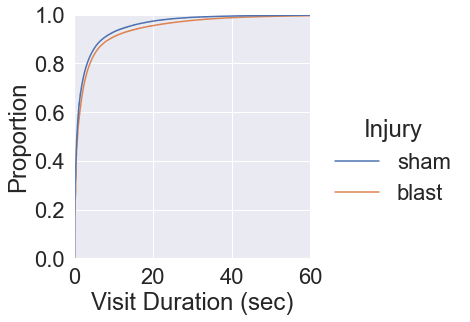

In [24]:
data_int = data_RFID_final
sns.displot(data=data_int, x="eventDuration", kind="ecdf", hue='Injury')
plt.xlabel('Visit Duration (sec)')
plt.xlim(0, 60)
plt.show()

<Figure size 720x360 with 0 Axes>

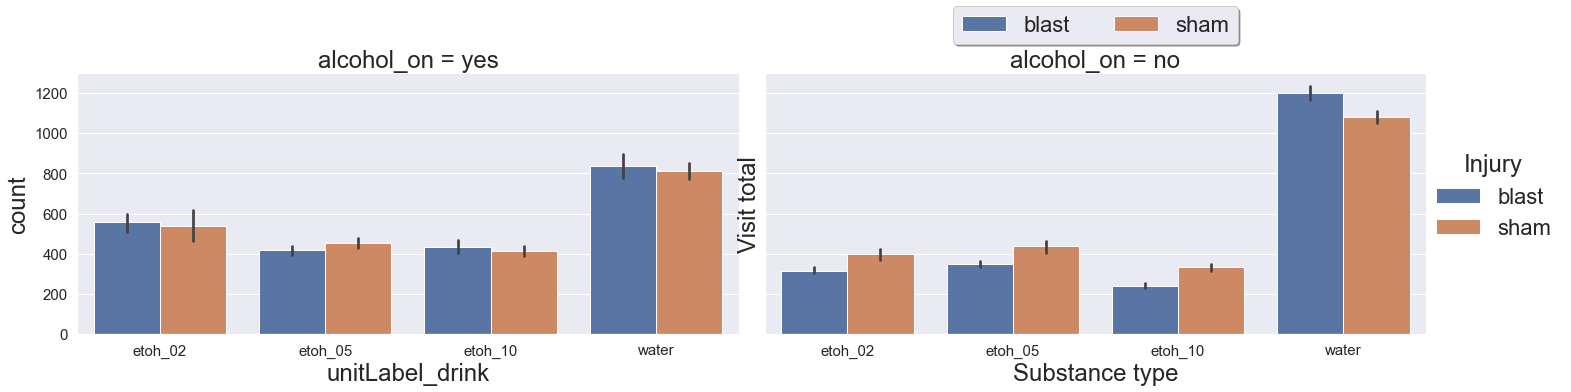

In [25]:
data_int = data_RFID_final

data_int = data_int.groupby(['Injury', 'IdRFID', 'Cage_N', 'ld_day', 'alcohol_on', 'unitLabel_drink'])['eventDuration'].sum().reset_index(name='count')
d = data_int[data_int['Cage_N']==4]

plt.figure(figsize=(10,5))
params = {'axes.labelsize': 30,
          'axes.titlesize': 30}
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

sns.catplot(data=d, x="unitLabel_drink", y='count', hue="Injury", kind='bar', height=5, aspect=2, ci=68,
           col='alcohol_on')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), 
          ncol=5, fancybox=True, shadow=True)
plt.xlabel('Substance type')
plt.ylabel('Visit total')
plt.show()

### VDM data

#### Get paths for files to process

In [26]:
#create list of dir paths
VDM_path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1'
  
VDM_file_names = os.listdir(VDM_path)

VDM_data_dir_paths = []

for file in VDM_file_names:
    int_path = VDM_path + '/' + file
    VDM_data_dir_paths.append(int_path)
    
VDM_data_dir_paths

['/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/e05_e10_e2.5_w_MPc1_221204.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/.DS_Store',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/w_e05_e10_e2.5_MPc1_221118.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/w_e05_e10_e2.5_MPc1_221125.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/w_e05_e10_e2.5_MPc1_221202.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/w_e05_e10_e2.5_MPc1_221114.csv',
 '/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/w_e05_e10_e2.5_MPc1_221111.csv']

#### Clean df and remove starting meta data

In [27]:
data_VDM_int = pd.read_table(VDM_data_dir_paths[2], sep=';')
data_VDM_int = pd.DataFrame(data = data_VDM_int)
data_VDM_int.head(50)

,Columbus Instruments Device Interface Version 1.5
0,"Started On:,11/18/22 14:33:12"
1,[Experiment Setup Info]
2,"Program Path:,C:\Users\PhenoUser\Desktop\CI Multi-Device Interface"
3,"Data Path:,C:\Users\PhenoUser\Desktop\CI Multi-Device Interface\Data"
4,"Experiment File Name:,C:\Users\PhenoUser\Documents\VDM\final_setup\w_e05_e10_e2.5_MPc1_221118.csv"
5,"Session Interval:,00:00:01"
6,"Experiment Duration:,0"
7,"Staggered Start Enable:,False"
8,[Channel Setup Info]
9,"Cage 1,Cage1"


In [28]:
row_drop = 22
data_VDM = pd.DataFrame()

for path in VDM_data_dir_paths:
    print(path)
    
    if path.split('/')[-1] == '.DS_Store':
        continue
        
    #create data table
    data_VDM_int = pd.read_table(path, sep=';')
    data_VDM_int = pd.DataFrame(data = data_VDM_int)
    data_VDM_int = data_VDM_int.iloc[row_drop: , :]['Columbus Instruments Device Interface Version 1.5'].str.split(',', expand=True)
    data_VDM_int.columns = data_VDM_int.loc[row_drop].values
    data_VDM_int = data_VDM_int.drop(row_drop)
    
    data_VDM_int['VDM_file'] = path.split('/')[-1]

    if data_VDM.empty:
        data_VDM = data_VDM_int
    else:
        data_VDM = pd.concat([data_VDM, data_VDM_int], axis=0)
        
    print(data_VDM.shape,'\n')

print(data_VDM.shape)
data_VDM.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/e05_e10_e2.5_w_MPc1_221204.csv
(2177946, 13) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/.DS_Store
/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/w_e05_e10_e2.5_MPc1_221118.csv
(5235250, 13) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/w_e05_e10_e2.5_MPc1_221125.csv
(8266729, 13) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/w_e05_e10_e2.5_MPc1_221202.csv
(9140625, 13) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/w_e05_e10_e2.5_MPc1_221114.csv
(10879303, 13) 

/Users/abbieschindler/Documents/Schindler_Lab/Data/RFID_VDM/MP/VDM/round1/w_e05_e10_e2.5_MPc1_221111.csv
(12111679, 13) 

(12111679, 13)


,Int,Cage,Time,Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),Drinking (ml),Drinking Accum (ml),,VDM_file
23,0,1,12/04/22 16:22:20,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,e05_e10_e2.5_w_MPc1_221204.csv
24,0,2,12/04/22 16:22:20,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,e05_e10_e2.5_w_MPc1_221204.csv
25,0,3,12/04/22 16:22:20,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,e05_e10_e2.5_w_MPc1_221204.csv
26,0,4,12/04/22 16:22:20,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,e05_e10_e2.5_w_MPc1_221204.csv
27,0,5,12/04/22 16:22:20,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,,e05_e10_e2.5_w_MPc1_221204.csv


In [29]:
data_VDM.columns = ['Int', 'Cage_VDM', 'VDM_Time', 
                    'drink_1', 'drink_1_accum',
                    'drink_2', 'drink_2_accum',
                    'drink_3', 'drink_3_accum',
                    'drink_4', 'drink_4_accum',
                    'blank', 'VDM_file']

data_VDM = data_VDM[['VDM_file', 'Cage_VDM', 'VDM_Time', 
                    'drink_1', 
                    'drink_2', 
                    'drink_3', 
                    'drink_4', 
                    ]]

data_VDM.tail()

,VDM_file,Cage_VDM,VDM_Time,drink_1,drink_2,drink_3,drink_4
1232394,w_e05_e10_e2.5_MPc1_221111.csv,4,11/14/22 14:20:26,0.000,0.000,0.000,0.000
1232395,w_e05_e10_e2.5_MPc1_221111.csv,5,11/14/22 14:20:26,0.000,0.000,0.000,0.000
1232396,w_e05_e10_e2.5_MPc1_221111.csv,6,11/14/22 14:20:26,0.000,0.000,0.000,0.000
1232397,w_e05_e10_e2.5_MPc1_221111.csv,7,11/14/22 14:20:26,0.000,0.000,0.000,0.000
1232398,w_e05_e10_e2.5_MPc1_221111.csv,8,11/14/22 14:20:26,0.000,0.000,0.000,0.000


#### Make into tidy df

In [30]:
#melt dataframe (new column of parameters)

meta_params = ['VDM_file', 'Cage_VDM', 'VDM_Time']
intake_params = ['drink_1', 'drink_2', 'drink_3', 'drink_4']

data_VDM_tidy = pd.melt(data_VDM, id_vars=meta_params, value_vars=intake_params)

data_VDM_tidy = data_VDM_tidy.replace({'':0.000})

data_VDM_tidy['value'] = data_VDM_tidy['value'].astype('float')

print(data_VDM_tidy.shape)
data_VDM_tidy.head()

(48446716, 5)


,VDM_file,Cage_VDM,VDM_Time,variable,value
0,e05_e10_e2.5_w_MPc1_221204.csv,1,12/04/22 16:22:20,drink_1,0.0
1,e05_e10_e2.5_w_MPc1_221204.csv,2,12/04/22 16:22:20,drink_1,0.0
2,e05_e10_e2.5_w_MPc1_221204.csv,3,12/04/22 16:22:20,drink_1,0.0
3,e05_e10_e2.5_w_MPc1_221204.csv,4,12/04/22 16:22:20,drink_1,0.0
4,e05_e10_e2.5_w_MPc1_221204.csv,5,12/04/22 16:22:20,drink_1,0.0


In [31]:
data_VDM_tidy['value'].unique()

array([0.   , 0.021, 0.042, 0.063, 0.084, 0.105, 0.126, 0.168, 0.147,
       0.189])

#### Drop times with no intake data

In [32]:
data_VDM_tidy_intake = data_VDM_tidy[data_VDM_tidy['value'] > 0.000]
print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(52500, 5)


,VDM_file,Cage_VDM,VDM_Time,variable,value
8,e05_e10_e2.5_w_MPc1_221204.csv,1,12/04/22 16:22:21,drink_1,0.021
9,e05_e10_e2.5_w_MPc1_221204.csv,2,12/04/22 16:22:21,drink_1,0.021
10,e05_e10_e2.5_w_MPc1_221204.csv,3,12/04/22 16:22:21,drink_1,0.021
12,e05_e10_e2.5_w_MPc1_221204.csv,5,12/04/22 16:22:21,drink_1,0.042
44,e05_e10_e2.5_w_MPc1_221204.csv,5,12/04/22 16:22:28,drink_1,0.021


#### Clean up datetime

In [33]:
#clean up and create datetime columns
data_VDM_tidy_intake['VDM_datetime'] = pd.to_datetime(data_VDM_tidy_intake['VDM_Time'])
data_VDM_tidy_intake['VDM_timestamp'] = [x.timestamp() for x in data_VDM_tidy_intake['VDM_datetime']]

data_VDM_tidy_intake['VDM_date'] = data_VDM_tidy_intake['VDM_datetime'].dt.date
data_VDM_tidy_intake['VDM_day'] = data_VDM_tidy_intake['VDM_datetime'].dt.day
data_VDM_tidy_intake['VDM_time'] = data_VDM_tidy_intake['VDM_datetime'].dt.strftime("%H:%M:%S")
data_VDM_tidy_intake['VDM_hour'] = data_VDM_tidy_intake['VDM_datetime'].dt.hour
data_VDM_tidy_intake['VDM_min'] = data_VDM_tidy_intake['VDM_datetime'].dt.minute
data_VDM_tidy_intake['VDM_second'] = data_VDM_tidy_intake['VDM_datetime'].dt.second

print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

(52500, 13)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second
8,e05_e10_e2.5_w_MPc1_221204.csv,1,12/04/22 16:22:21,drink_1,0.021,2022-12-04 16:22:21,1.670171e+09,2022-12-04,4,16:22:21,16,22,21
9,e05_e10_e2.5_w_MPc1_221204.csv,2,12/04/22 16:22:21,drink_1,0.021,2022-12-04 16:22:21,1.670171e+09,2022-12-04,4,16:22:21,16,22,21
10,e05_e10_e2.5_w_MPc1_221204.csv,3,12/04/22 16:22:21,drink_1,0.021,2022-12-04 16:22:21,1.670171e+09,2022-12-04,4,16:22:21,16,22,21
12,e05_e10_e2.5_w_MPc1_221204.csv,5,12/04/22 16:22:21,drink_1,0.042,2022-12-04 16:22:21,1.670171e+09,2022-12-04,4,16:22:21,16,22,21
44,e05_e10_e2.5_w_MPc1_221204.csv,5,12/04/22 16:22:28,drink_1,0.021,2022-12-04 16:22:28,1.670171e+09,2022-12-04,4,16:22:28,16,22,28


In [34]:
data_VDM_tidy_intake['VDM_day'].value_counts()

17    2160
12    2150
20    2030
2     2020
25    2006
18    1998
28    1986
22    1942
1     1899
16    1897
15    1895
21    1888
4     1882
7     1876
27    1875
29    1873
13    1863
6     1861
8     1803
24    1801
23    1799
5     1790
30    1783
3     1763
19    1755
26    1726
14    1720
9     1092
11    367 
Name: VDM_day, dtype: int64

#### Light/dark mapping

In [35]:
def assign_ld(time):
    if (time >= 6) & (time < 18):
        return 'light'
    if (time >= 0) & (time < 6):
        return 'dark_am'
    if (time >= 18):
        return 'dark_pm'
    
data_VDM_tidy_intake['ld_seg'] = data_VDM_tidy_intake['VDM_hour'].apply(assign_ld)

data_VDM_tidy_intake.head()

,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg
8,e05_e10_e2.5_w_MPc1_221204.csv,1,12/04/22 16:22:21,drink_1,0.021,2022-12-04 16:22:21,1.670171e+09,2022-12-04,4,16:22:21,16,22,21,light
9,e05_e10_e2.5_w_MPc1_221204.csv,2,12/04/22 16:22:21,drink_1,0.021,2022-12-04 16:22:21,1.670171e+09,2022-12-04,4,16:22:21,16,22,21,light
10,e05_e10_e2.5_w_MPc1_221204.csv,3,12/04/22 16:22:21,drink_1,0.021,2022-12-04 16:22:21,1.670171e+09,2022-12-04,4,16:22:21,16,22,21,light
12,e05_e10_e2.5_w_MPc1_221204.csv,5,12/04/22 16:22:21,drink_1,0.042,2022-12-04 16:22:21,1.670171e+09,2022-12-04,4,16:22:21,16,22,21,light
44,e05_e10_e2.5_w_MPc1_221204.csv,5,12/04/22 16:22:28,drink_1,0.021,2022-12-04 16:22:28,1.670171e+09,2022-12-04,4,16:22:28,16,22,28,light


In [36]:
data_VDM_tidy_intake['VDM_file'].value_counts()

w_e05_e10_e2.5_MPc1_221118.csv    13262
w_e05_e10_e2.5_MPc1_221125.csv    13177
e05_e10_e2.5_w_MPc1_221204.csv    9317 
w_e05_e10_e2.5_MPc1_221114.csv    7912 
w_e05_e10_e2.5_MPc1_221111.csv    5236 
w_e05_e10_e2.5_MPc1_221202.csv    3596 
Name: VDM_file, dtype: int64

#### Map bottle contents

In [37]:
contents_map = {'drink_1':'water',
                'drink_2':'etoh_05',
                'drink_3':'etoh_10',
                'drink_4':'etoh_02',
               }

data_VDM_tidy_intake['VDM_drink'] = data_VDM_tidy_intake['variable'].map(contents_map)

data_VDM_tidy_intake.head()

,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink
8,e05_e10_e2.5_w_MPc1_221204.csv,1,12/04/22 16:22:21,drink_1,0.021,2022-12-04 16:22:21,1.670171e+09,2022-12-04,4,16:22:21,16,22,21,light,water
9,e05_e10_e2.5_w_MPc1_221204.csv,2,12/04/22 16:22:21,drink_1,0.021,2022-12-04 16:22:21,1.670171e+09,2022-12-04,4,16:22:21,16,22,21,light,water
10,e05_e10_e2.5_w_MPc1_221204.csv,3,12/04/22 16:22:21,drink_1,0.021,2022-12-04 16:22:21,1.670171e+09,2022-12-04,4,16:22:21,16,22,21,light,water
12,e05_e10_e2.5_w_MPc1_221204.csv,5,12/04/22 16:22:21,drink_1,0.042,2022-12-04 16:22:21,1.670171e+09,2022-12-04,4,16:22:21,16,22,21,light,water
44,e05_e10_e2.5_w_MPc1_221204.csv,5,12/04/22 16:22:28,drink_1,0.021,2022-12-04 16:22:28,1.670171e+09,2022-12-04,4,16:22:28,16,22,28,light,water


In [ ]:
contents_map = {'drink_1':'water',
                'drink_2':'etoh_10',
                'drink_3':'etoh_20',
                'drink_4':'etoh_05',
               }

data_VDM_tidy_intake['VDM_drink'] = data_VDM_tidy_intake['variable'].map(contents_map)

data_VDM_tidy_intake.head()

#### Viz

No handles with labels found to put in legend.


<Figure size 720x360 with 0 Axes>

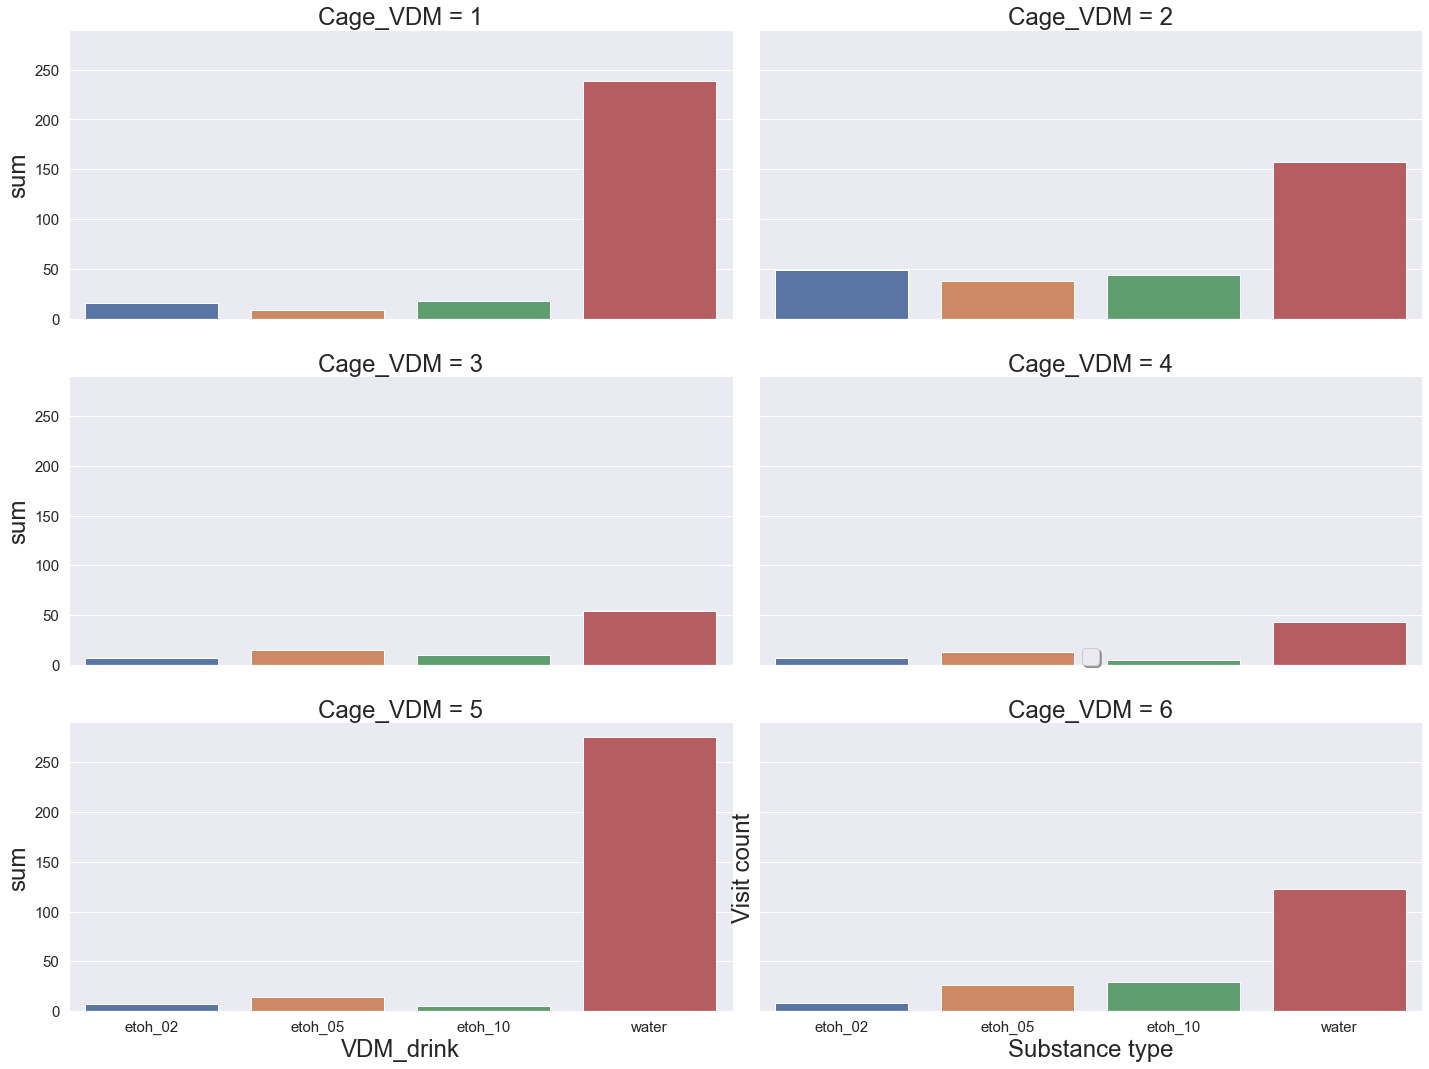

In [38]:
data_int = data_VDM_tidy_intake.groupby(['Cage_VDM', 'VDM_drink'])['value'].sum().reset_index(name='sum')

plt.figure(figsize=(10,5))
params = {'axes.labelsize': 30,
          'axes.titlesize': 30}
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
sns.catplot(data=data_int, x="VDM_drink", y='sum', kind='bar', height=5, aspect=2, 
            col='Cage_VDM', col_wrap=2)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=5, fancybox=True, shadow=True)
plt.xlabel('Substance type')
plt.ylabel('Visit count')
plt.show()

### Filter RFID data by VDM times

In [39]:
data_VDM_tidy_intake = data_VDM_tidy_intake.sort_values(['VDM_drink', 'VDM_datetime']).reset_index(drop=True)

print(data_VDM_tidy_intake['VDM_drink'].value_counts())
print(data_VDM_tidy_intake.shape)
data_VDM_tidy_intake.head()

water      39005
etoh_10    5008 
etoh_05    4424 
etoh_02    4063 
Name: VDM_drink, dtype: int64
(52500, 15)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink
0,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 18:43:37,drink_4,0.021,2022-11-11 18:43:37,1.668192e+09,2022-11-11,11,18:43:37,18,43,37,dark_pm,etoh_02
1,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 19:51:51,drink_4,0.021,2022-11-11 19:51:51,1.668196e+09,2022-11-11,11,19:51:51,19,51,51,dark_pm,etoh_02
2,w_e05_e10_e2.5_MPc1_221111.csv,3,11/11/22 20:30:10,drink_4,0.021,2022-11-11 20:30:10,1.668199e+09,2022-11-11,11,20:30:10,20,30,10,dark_pm,etoh_02
3,w_e05_e10_e2.5_MPc1_221111.csv,6,11/11/22 21:05:50,drink_4,0.021,2022-11-11 21:05:50,1.668201e+09,2022-11-11,11,21:05:50,21,5,50,dark_pm,etoh_02
4,w_e05_e10_e2.5_MPc1_221111.csv,6,11/11/22 21:06:27,drink_4,0.021,2022-11-11 21:06:27,1.668201e+09,2022-11-11,11,21:06:27,21,6,27,dark_pm,etoh_02


In [40]:
data_RFID_final= data_RFID_final.sort_values(['unitLabel_drink', 'RFID_datetime_start']).reset_index(drop=True)
print(data_RFID_final['unitLabel_drink'].value_counts())
data_RFID_final.head()

water      99808
etoh_05    98151
etoh_10    78153
etoh_02    71592
Name: unitLabel_drink, dtype: int64


,Round,Timepoint,Cage,IdRFID,Animal,Injury,Sex,Cage_N,unitLabel_drink,unitLabel,eventDuration,ld_cycle,ld_day,day,alcohol_on,after_weekend,RFID_hour,RFID_min,RFID_second,RFID_datetime_start,RFID_datetime_end,RFID_time_start,RFID_time_end,RFID_min_count,RFID_sec_count,RFID_hour_count_running,RFID_min_count_running,RFID_sec_count_running,RFID_file,22_11_11,22_11_18,22_11_25,22_12_02,23_01_06,23_01_13,23_01_20,23_01_27
0,MPc1,1m,1,041ABFF7BC,2154,sham,male,4,etoh_02,Spyder1.20,2.290,dark,1,0,yes,0,18,8,38,2022-11-11 18:08:38.854982399,2022-11-11 18:08:41.144982399,18:08:38,18:08:41,1088,65318,-6,-352,-21142,Idspyder-22.11.11.csv,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8
1,MPc1,1m,1,041AC161AF,2155,sham,male,4,etoh_02,Spyder1.20,2.862,dark,1,0,yes,0,18,9,12,2022-11-11 18:09:12.057984000,2022-11-11 18:09:14.919984000,18:09:12,18:09:14,1089,65352,-6,-351,-21108,Idspyder-22.11.11.csv,30.3,30.3,30.9,31.0,35.7,34.1,36.5,36.7
2,MPc1,1m,1,041AC165C3,2156,sham,male,4,etoh_02,Spyder1.20,4.378,dark,1,0,yes,0,18,9,31,2022-11-11 18:09:31.833993600,2022-11-11 18:09:36.211993600,18:09:31,18:09:36,1089,65371,-6,-351,-21089,Idspyder-22.11.11.csv,29.6,28.8,28.5,29.5,35.6,33.6,34.4,34.4
3,MPc1,1m,1,041AC1685B,2157,sham,male,4,etoh_02,Spyder1.20,3.047,dark,1,0,yes,0,18,9,45,2022-11-11 18:09:45.326044800,2022-11-11 18:09:48.373044800,18:09:45,18:09:48,1089,65385,-6,-351,-21075,Idspyder-22.11.11.csv,34.5,33.2,34.0,34.5,42.1,38.6,39.7,40.8
4,MPc1,1m,2,041AC16024,2207,blast,male,4,etoh_02,Spyder1.20,1.603,dark,1,0,yes,0,18,10,43,2022-11-11 18:10:43.885977600,2022-11-11 18:10:45.488977600,18:10:43,18:10:45,1090,65443,-6,-350,-21017,Idspyder-22.11.11.csv,32.2,32.8,33.5,34.2,36.0,34.3,35.6,36.6


#### Match cage, unitLabel, and datetime

In [41]:
data_comb = data_VDM_tidy_intake

RFID_eventDuration = []
RFID_assign_id_pre = []
RFID_assign_var_pre = []
RFID_datetime_start_pre = []
RFID_datetime_end_pre = []

ld_cycle = []
ld_day = []
alcohol_on = []
after_weekend = []

for index, row in data_VDM_tidy_intake.iterrows():
    if index%1000 == 0:
        print(index)
        
    #find RFID signal start time closest to VDM time before
    try:
        int_assign = data_RFID_final[(data_RFID_final['Cage'] == int(row['Cage_VDM'])) & #match cage
                               (data_RFID_final['unitLabel_drink'] == row['VDM_drink']) & #match tube
                               (data_RFID_final['RFID_datetime_start'] <= row['VDM_datetime']) #find closest datetime
                              ].sort_values(['RFID_datetime_start']).iloc[-1]

        RFID_eventDuration.append(int_assign['eventDuration'])
        RFID_assign_id_pre.append(int_assign['IdRFID'])
        RFID_assign_var_pre.append(int_assign['unitLabel_drink'])
        RFID_datetime_start_pre.append(int_assign['RFID_datetime_start'])
        RFID_datetime_end_pre.append(int_assign['RFID_datetime_end'])

        ld_cycle.append(int_assign['ld_cycle'])
        ld_day.append(int_assign['ld_day'])
        alcohol_on.append(int_assign['alcohol_on'])
        after_weekend.append(int_assign['after_weekend'])
        
    except:
        print(index, 'pre', row['Cage_VDM'])
        RFID_eventDuration.append(np.nan)
        RFID_assign_id_pre.append(np.nan)
        RFID_assign_var_pre.append(np.nan)
        RFID_datetime_start_pre.append(np.nan)
        RFID_datetime_end_pre.append(np.nan)

        ld_cycle.append(np.nan)
        ld_day.append(np.nan)
        alcohol_on.append(np.nan)
        after_weekend.append(np.nan)
        
data_comb['RFID_eventDuration'] = RFID_eventDuration
data_comb['RFID_assign_id_pre'] = RFID_assign_id_pre
data_comb['RFID_assign_var_pre'] = RFID_assign_var_pre
data_comb['RFID_datetime_start_pre'] = RFID_datetime_start_pre
data_comb['RFID_datetime_end_pre'] = RFID_datetime_end_pre

data_comb['ld_cycle'] = ld_cycle
data_comb['ld_day'] = ld_day
data_comb['alcohol_on'] = alcohol_on
data_comb['after_weekend'] = after_weekend

print(data_comb.shape)
data_comb.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
(52500, 24)


,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,alcohol_on,after_weekend
0,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 18:43:37,drink_4,0.021,2022-11-11 18:43:37,1.668192e+09,2022-11-11,11,18:43:37,18,43,37,dark_pm,etoh_02,13.725,041AC1685B,etoh_02,2022-11-11 18:43:27.374966400,2022-11-11 18:43:41.099966400,dark,1,yes,0
1,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 19:51:51,drink_4,0.021,2022-11-11 19:51:51,1.668196e+09,2022-11-11,11,19:51:51,19,51,51,dark_pm,etoh_02,8.770,041ABFF7BC,etoh_02,2022-11-11 19:51:44.387020800,2022-11-11 19:51:53.157020800,dark,1,yes,0
2,w_e05_e10_e2.5_MPc1_221111.csv,3,11/11/22 20:30:10,drink_4,0.021,2022-11-11 20:30:10,1.668199e+09,2022-11-11,11,20:30:10,20,30,10,dark_pm,etoh_02,26.607,041AC035B7,etoh_02,2022-11-11 20:29:53.562969600,2022-11-11 20:30:20.169969600,dark,1,yes,0
3,w_e05_e10_e2.5_MPc1_221111.csv,6,11/11/22 21:05:50,drink_4,0.021,2022-11-11 21:05:50,1.668201e+09,2022-11-11,11,21:05:50,21,5,50,dark_pm,etoh_02,53.519,041AC16B8D,etoh_02,2022-11-11 21:05:10.989974400,2022-11-11 21:06:04.508974400,dark,1,yes,0
4,w_e05_e10_e2.5_MPc1_221111.csv,6,11/11/22 21:06:27,drink_4,0.021,2022-11-11 21:06:27,1.668201e+09,2022-11-11,11,21:06:27,21,6,27,dark_pm,etoh_02,25.343,041AC16B8D,etoh_02,2022-11-11 21:06:21.560976000,2022-11-11 21:06:46.903976000,dark,1,yes,0


In [42]:
data_comb.isna().sum()

VDM_file                   0
Cage_VDM                   0
VDM_Time                   0
variable                   0
value                      0
VDM_datetime               0
VDM_timestamp              0
VDM_date                   0
VDM_day                    0
VDM_time                   0
VDM_hour                   0
VDM_min                    0
VDM_second                 0
ld_seg                     0
VDM_drink                  0
RFID_eventDuration         0
RFID_assign_id_pre         0
RFID_assign_var_pre        0
RFID_datetime_start_pre    0
RFID_datetime_end_pre      0
ld_cycle                   0
ld_day                     0
alcohol_on                 0
after_weekend              0
dtype: int64

#### Copmuter RFID/VDM time difference

In [43]:
def time_within(RFID_start, RFID_stop, VDM_time):
    
    if (VDM_time >= RFID_start) & (VDM_time <= RFID_stop):
        return 0
    
    elif (VDM_time >= RFID_start) & (VDM_time >= RFID_stop):
        time_within = VDM_time - RFID_stop
        time_within = time_within.total_seconds()
        return time_within
    
data_comb['VDM_RFID_timediff'] = data_comb.apply(lambda row: time_within(row['RFID_datetime_start_pre'], 
                                                                   row['RFID_datetime_end_pre'],
                                                                   row['VDM_datetime']), axis=1)

data_comb['VDM_RFID_timediff_bool'] = ['same' if x==0 else 'diff' for x in data_comb['VDM_RFID_timediff']]

data_comb.head()

,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,alcohol_on,after_weekend,VDM_RFID_timediff,VDM_RFID_timediff_bool
0,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 18:43:37,drink_4,0.021,2022-11-11 18:43:37,1.668192e+09,2022-11-11,11,18:43:37,18,43,37,dark_pm,etoh_02,13.725,041AC1685B,etoh_02,2022-11-11 18:43:27.374966400,2022-11-11 18:43:41.099966400,dark,1,yes,0,0.0,same
1,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 19:51:51,drink_4,0.021,2022-11-11 19:51:51,1.668196e+09,2022-11-11,11,19:51:51,19,51,51,dark_pm,etoh_02,8.770,041ABFF7BC,etoh_02,2022-11-11 19:51:44.387020800,2022-11-11 19:51:53.157020800,dark,1,yes,0,0.0,same
2,w_e05_e10_e2.5_MPc1_221111.csv,3,11/11/22 20:30:10,drink_4,0.021,2022-11-11 20:30:10,1.668199e+09,2022-11-11,11,20:30:10,20,30,10,dark_pm,etoh_02,26.607,041AC035B7,etoh_02,2022-11-11 20:29:53.562969600,2022-11-11 20:30:20.169969600,dark,1,yes,0,0.0,same
3,w_e05_e10_e2.5_MPc1_221111.csv,6,11/11/22 21:05:50,drink_4,0.021,2022-11-11 21:05:50,1.668201e+09,2022-11-11,11,21:05:50,21,5,50,dark_pm,etoh_02,53.519,041AC16B8D,etoh_02,2022-11-11 21:05:10.989974400,2022-11-11 21:06:04.508974400,dark,1,yes,0,0.0,same
4,w_e05_e10_e2.5_MPc1_221111.csv,6,11/11/22 21:06:27,drink_4,0.021,2022-11-11 21:06:27,1.668201e+09,2022-11-11,11,21:06:27,21,6,27,dark_pm,etoh_02,25.343,041AC16B8D,etoh_02,2022-11-11 21:06:21.560976000,2022-11-11 21:06:46.903976000,dark,1,yes,0,0.0,same


In [44]:
data_comb.groupby(['Cage_VDM', 'VDM_drink', ])['VDM_RFID_timediff_bool'].value_counts()

Cage_VDM  VDM_drink  VDM_RFID_timediff_bool
1         etoh_02    diff                      487  
                     same                      249  
          etoh_05    same                      211  
                     diff                      189  
          etoh_10    same                      534  
                     diff                      273  
          water      same                      8979 
                     diff                      2174 
2         etoh_02    same                      1769 
                     diff                      264  
          etoh_05    same                      1442 
                     diff                      210  
          etoh_10    same                      1854 
                     diff                      191  
          water      same                      6518 
                     diff                      935  
3         etoh_02    same                      170  
                     diff                      148  
  

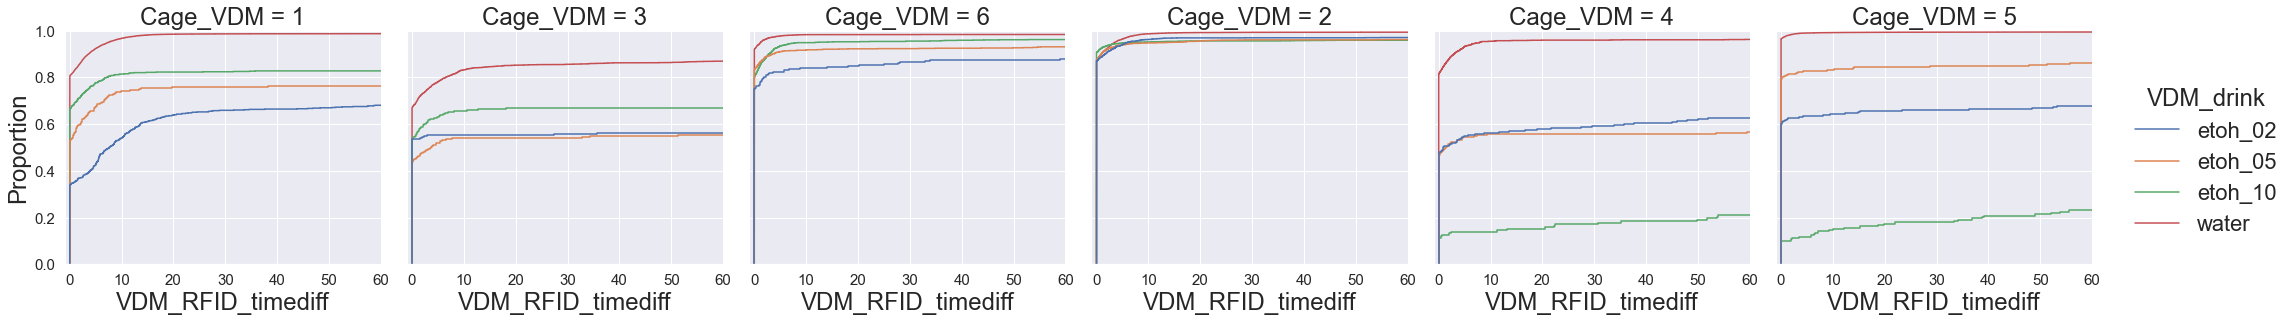

In [45]:
sns.displot(data=data_comb, x="VDM_RFID_timediff", kind="ecdf", hue='VDM_drink', col='Cage_VDM')

plt.xlim(-1, 60)
plt.show()

#### Add metadata

In [46]:
data_comb = meta_data.merge(data_comb.reset_index(), left_on='IdRFID', right_on='RFID_assign_id_pre', sort=False)

print(data_comb.shape)
data_comb.head()

(52500, 46)


,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,22_11_11,22_11_18,22_11_25,22_12_02,23_01_06,23_01_13,23_01_20,23_01_27,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,alcohol_on,after_weekend,VDM_RFID_timediff,VDM_RFID_timediff_bool
0,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,1,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 19:51:51,drink_4,0.021,2022-11-11 19:51:51,1.668196e+09,2022-11-11,11,19:51:51,19,51,51,dark_pm,etoh_02,8.770,041ABFF7BC,etoh_02,2022-11-11 19:51:44.387020800,2022-11-11 19:51:53.157020800,dark,1,yes,0,0.000000,same
1,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,5,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 21:15:56,drink_4,0.021,2022-11-11 21:15:56,1.668201e+09,2022-11-11,11,21:15:56,21,15,56,dark_pm,etoh_02,3.592,041ABFF7BC,etoh_02,2022-11-11 21:14:55.025030400,2022-11-11 21:14:58.617030400,dark,1,yes,0,57.382969,diff
2,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,19,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 21:46:35,drink_4,0.021,2022-11-11 21:46:35,1.668203e+09,2022-11-11,11,21:46:35,21,46,35,dark_pm,etoh_02,0.075,041ABFF7BC,etoh_02,2022-11-11 21:46:33.672979200,2022-11-11 21:46:33.747979200,dark,1,yes,0,1.252020,diff
3,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,20,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 21:46:38,drink_4,0.021,2022-11-11 21:46:38,1.668203e+09,2022-11-11,11,21:46:38,21,46,38,dark_pm,etoh_02,0.075,041ABFF7BC,etoh_02,2022-11-11 21:46:33.672979200,2022-11-11 21:46:33.747979200,dark,1,yes,0,4.252020,diff
4,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,97,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 23:12:05,drink_4,0.021,2022-11-11 23:12:05,1.668208e+09,2022-11-11,11,23:12:05,23,12,5,dark_pm,etoh_02,0.075,041ABFF7BC,etoh_02,2022-11-11 23:12:00.096019200,2022-11-11 23:12:00.171019200,dark,1,yes,0,4.828980,diff


#### Add hour and min counts

In [47]:
#column of running min and second count within each day
data_comb['min_count'] = (data_comb['VDM_hour']*60) + data_comb['VDM_min'] 
data_comb['sec_count'] = (data_comb['min_count']*60) + data_comb['VDM_second'] 

#column of running hour and minute count across all days
data_comb['hour_count_running'] = (data_comb['ld_day']*24) + data_comb['VDM_hour'] - 24
data_comb['min_count_running'] = (data_comb['hour_count_running']*60) + data_comb['VDM_min'] 
data_comb['sec_count_running'] = (data_comb['min_count_running']*60) + data_comb['VDM_second'] - 60

print(data_comb.shape)
data_comb.head()

(52500, 51)


,Round,Build,Startdate,Timepoint,Cage,IdRFID,Animal,ARF_Cage,Injury,Sex,Cage_N,22_11_11,22_11_18,22_11_25,22_12_02,23_01_06,23_01_13,23_01_20,23_01_27,index,VDM_file,Cage_VDM,VDM_Time,variable,value,VDM_datetime,VDM_timestamp,VDM_date,VDM_day,VDM_time,VDM_hour,VDM_min,VDM_second,ld_seg,VDM_drink,RFID_eventDuration,RFID_assign_id_pre,RFID_assign_var_pre,RFID_datetime_start_pre,RFID_datetime_end_pre,ld_cycle,ld_day,alcohol_on,after_weekend,VDM_RFID_timediff,VDM_RFID_timediff_bool,min_count,sec_count,hour_count_running,min_count_running,sec_count_running
0,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,1,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 19:51:51,drink_4,0.021,2022-11-11 19:51:51,1.668196e+09,2022-11-11,11,19:51:51,19,51,51,dark_pm,etoh_02,8.770,041ABFF7BC,etoh_02,2022-11-11 19:51:44.387020800,2022-11-11 19:51:53.157020800,dark,1,yes,0,0.000000,same,1191,71511,19,1191,71451
1,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,5,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 21:15:56,drink_4,0.021,2022-11-11 21:15:56,1.668201e+09,2022-11-11,11,21:15:56,21,15,56,dark_pm,etoh_02,3.592,041ABFF7BC,etoh_02,2022-11-11 21:14:55.025030400,2022-11-11 21:14:58.617030400,dark,1,yes,0,57.382969,diff,1275,76556,21,1275,76496
2,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,19,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 21:46:35,drink_4,0.021,2022-11-11 21:46:35,1.668203e+09,2022-11-11,11,21:46:35,21,46,35,dark_pm,etoh_02,0.075,041ABFF7BC,etoh_02,2022-11-11 21:46:33.672979200,2022-11-11 21:46:33.747979200,dark,1,yes,0,1.252020,diff,1306,78395,21,1306,78335
3,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,20,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 21:46:38,drink_4,0.021,2022-11-11 21:46:38,1.668203e+09,2022-11-11,11,21:46:38,21,46,38,dark_pm,etoh_02,0.075,041ABFF7BC,etoh_02,2022-11-11 21:46:33.672979200,2022-11-11 21:46:33.747979200,dark,1,yes,0,4.252020,diff,1306,78398,21,1306,78338
4,MPc1,4x6,22.11.11,1m,1,041ABFF7BC,2154,659,sham,male,4,30.7,28.6,29.3,30.0,37.5,36.4,36.4,36.8,97,w_e05_e10_e2.5_MPc1_221111.csv,1,11/11/22 23:12:05,drink_4,0.021,2022-11-11 23:12:05,1.668208e+09,2022-11-11,11,23:12:05,23,12,5,dark_pm,etoh_02,0.075,041ABFF7BC,etoh_02,2022-11-11 23:12:00.096019200,2022-11-11 23:12:00.171019200,dark,1,yes,0,4.828980,diff,1392,83525,23,1392,83465


In [48]:
data_comb.groupby(['ld_day', 'ld_cycle'])['VDM_date'].value_counts()

ld_day  ld_cycle  VDM_date  
1       dark      2022-11-12    509
                  2022-11-11    367
        light     2022-11-12    794
2       dark      2022-11-12    847
                  2022-11-13    433
        light     2022-11-13    587
3       dark      2022-11-13    843
                  2022-11-14    450
        light     2022-11-14    510
4       dark      2022-11-14    760
                  2022-11-15    596
        light     2022-11-15    501
5       dark      2022-11-15    798
                  2022-11-16    586
        light     2022-11-16    552
6       dark      2022-11-16    759
                  2022-11-17    679
        light     2022-11-17    620
7       dark      2022-11-17    861
                  2022-11-18    613
        light     2022-11-18    630
8       dark      2022-11-18    755
                  2022-11-19    477
        light     2022-11-19    533
9       dark      2022-11-19    745
                  2022-11-20    538
        light     2022-11-20    669

In [49]:
data_comb['substance'] = data_comb['VDM_drink']

In [50]:
data_comb.to_csv('etoh_r1.csv')